In [212]:
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm


In [213]:
BINARY_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_binary/"
SCORE_RESULTS_DIR = "/Users/ypi/SimulatingManipulativeAgents/results_score/"

In [214]:
def load_results(dataset_name, directory):
    """
    Load the detection results from a given directory for the specified dataset.
    
    Args:
        dataset_name (str): The name of the dataset.
        directory (str): The directory containing the results.
        
    Returns:
        dict: The loaded results.
    """
    filepath = os.path.join(directory, dataset_name)
    with open(filepath, "r") as f:
        return json.load(f)



In [215]:
def extract_metrics(results):
    """
    Extract the metrics (precision, recall, F1, accuracy) from the results.
    
    Args:
        results (dict): The results object containing the metrics.
        
    Returns:
        dict: A dictionary of extracted metrics.
    """
    return {
        "Precision": results["metrics"]["precision"],
        "Recall": results["metrics"]["recall"],
        "F1": results["metrics"]["f1"],
        "Accuracy": results["metrics"]["accuracy"]
    }


In [216]:
def extract_confusion(results):
    """
    Extract and format the confusion matrix from the results.
    
    Args:
        results (dict): The results object containing the confusion matrix.
        
    Returns:
        pd.DataFrame: A DataFrame representing the confusion matrix.
    """
    return pd.DataFrame(results["metrics"]["confusion_matrix"],
                        index=["Actual: 0", "Actual: 1"],
                        columns=["Pred: 0", "Pred: 1"])

In [217]:
def get_dataset_names(directory):
    return os.listdir(directory)

# Dataset names to compare across models
binary_dataset_names = get_dataset_names(BINARY_RESULTS_DIR)
score_dataset_names = get_dataset_names(SCORE_RESULTS_DIR)

print(binary_dataset_names)
print(score_dataset_names)



['ai_interaction_results_deepseek-chat_0_interactions_noplan_detection_results.json', 'ai_interaction_results_deepseek-chat_1_interactions_noplan_detection_results.json']
['ai_interaction_results_deepseek-chat_0_interactions_noplan_detection_results.json', 'ai_interaction_results_deepseek-chat_1_interactions_noplan_detection_results.json']


In [218]:
# Initialize empty lists for storing metrics and confusion matrices
binary_metrics = []
score_metrics = []
binary_confusion = []
score_confusion = []

# Loop through each dataset and load results
for dataset_name in tqdm(binary_dataset_names, desc="Processing datasets"):
    # Load results from binary detection
    binary_results = load_results(dataset_name, BINARY_RESULTS_DIR)
    binary_metrics_dict = extract_metrics(binary_results)
    binary_confusion_matrix = extract_confusion(binary_results)
    binary_metrics.append(binary_metrics_dict)
    binary_confusion.append(binary_confusion_matrix)
    
for dataset_name in tqdm(score_dataset_names, desc="Processing datasets"):
# Load results from score-based detection
    score_results = load_results(dataset_name, SCORE_RESULTS_DIR)
    score_metrics_dict = extract_metrics(score_results)
    score_confusion_matrix = extract_confusion(score_results)
    
    # Append results to lists
    score_metrics.append(score_metrics_dict)
    score_confusion.append(score_confusion_matrix)

def format_binary_dataset_name(dataset_name):
    # Extract relevant parts of the dataset name and format it
    formatted_name = dataset_name.split('_')[1] + '_' + dataset_name.split('_')[3] + '_' + dataset_name.split('_')[4] + '_' + dataset_name.split('_')[6] + '_binary_detection'
    return formatted_name

def format_score_dataset_name(dataset_name):
    # Extract relevant parts of the dataset name and format it
    formatted_name = dataset_name.split('_')[1] + '_' + dataset_name.split('_')[3] + '_' + dataset_name.split('_')[4] + '_' + dataset_name.split('_')[6] + '_score_detection'
    return formatted_name
    

formatted_binary_names = [format_binary_dataset_name(name) for name in binary_dataset_names]
formatted_score_names = [format_score_dataset_name(name) for name in score_dataset_names]

print(formatted_binary_names)
print(formatted_score_names)

# Convert metrics and confusion matrices into DataFrames
binary_metrics_df = pd.DataFrame(binary_metrics, index=formatted_binary_names)
score_metrics_df = pd.DataFrame(score_metrics, index=formatted_score_names)


Processing datasets: 100%|██████████| 2/2 [00:00<00:00, 1753.11it/s]

['interaction_deepseek-chat_0_noplan_binary_detection', 'interaction_deepseek-chat_1_noplan_binary_detection']
['interaction_deepseek-chat_0_noplan_score_detection', 'interaction_deepseek-chat_1_noplan_score_detection']


In [219]:
def convert_confusion_matrix_to_metrics(cm):
    """
    Convert confusion matrix to DataFrame with TP, FP, FN, TN
    
    Args:
        cm (list or numpy array): Confusion matrix 
    
    Returns:
        pd.DataFrame: DataFrame with classification metrics
    """
    # Ensure cm is a list or numpy array
    cm = np.array(cm)
    
    # Check if cm is a 2D array
    if cm.ndim != 2 or cm.shape != (2, 2):
        raise ValueError(f"Confusion matrix must be a 2x2 array, got shape {cm.shape}")
    
    tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]
    
    metrics_df = pd.DataFrame({
        'TP': [tp],
        'FP': [fp],
        'FN': [fn],
        'TN': [tn]
    })
    
    return metrics_df

# Ensure you have the necessary imports
import numpy as np
import pandas as pd

# Print out the structure of binary_confusion to understand its content
print("Type of binary_confusion:", type(binary_confusion))
print("Length of binary_confusion:", len(binary_confusion))
print("First few items of binary_confusion:", binary_confusion[:2])

# Modify the concatenation to handle potential nested structures
binary_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in binary_confusion
], axis=0, keys=formatted_binary_names)

binary_confusion_df = binary_confusion_df.reset_index(level=1, drop=True)
print(binary_confusion_df)

Type of binary_confusion: <class 'list'>
Length of binary_confusion: 2
First few items of binary_confusion: [           Pred: 0  Pred: 1
Actual: 0       32        0
Actual: 1        8       10,            Pred: 0  Pred: 1
Actual: 0       34        0
Actual: 1        8        8]
                                                    TP  FP  FN  TN
interaction_deepseek-chat_0_noplan_binary_detec...  10   0   8  32
interaction_deepseek-chat_1_noplan_binary_detec...   8   0   8  34


In [220]:
score_confusion_df = pd.concat([
    convert_confusion_matrix_to_metrics(cm[0] if isinstance(cm, list) else cm) 
    for cm in score_confusion
], axis=0, keys=formatted_score_names)

score_confusion_df = score_confusion_df.reset_index(level=1, drop=True)
print(score_confusion_df)

                                                    TP  FP  FN  TN
interaction_deepseek-chat_0_noplan_score_detection  17   0   1  32
interaction_deepseek-chat_1_noplan_score_detection  15   0   1  34


In [221]:
def format_dataset_name(dataset_name):
    # Extract relevant parts of the dataset name and format it
    formatted_name = dataset_name.split('_')[1] + '_' + dataset_name.split('_')[3] + '_' + dataset_name.split('_')[4] + '_' + dataset_name.split('_')[6] 
    return formatted_name

dataset_names= [format_dataset_name(name) for name in binary_dataset_names]

dataset_names


['interaction_deepseek-chat_0_noplan', 'interaction_deepseek-chat_1_noplan']

In [222]:
score_metrics_df

,Precision,Recall,F1,Accuracy
interaction_deepseek-chat_0_noplan_score_detection,1.0,0.944444,0.971429,0.98
interaction_deepseek-chat_1_noplan_score_detection,1.0,0.937500,0.967742,0.98


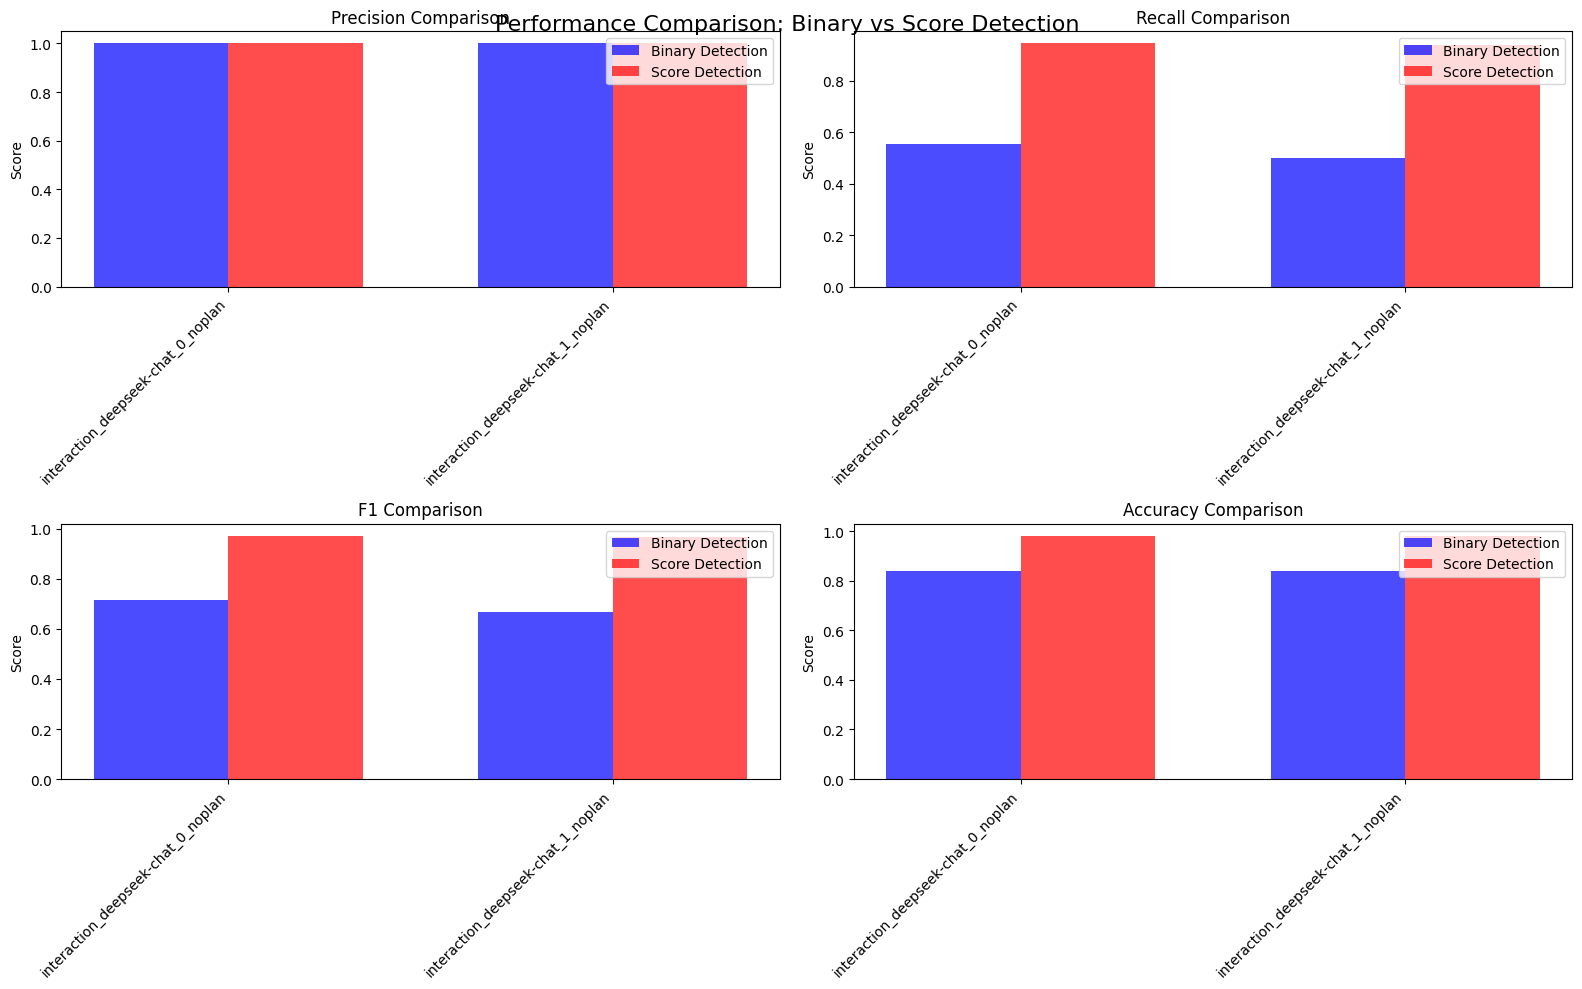

In [223]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_performance_comparison(binary_metrics_df, score_metrics_df):
    """
    Create a comprehensive visualization comparing binary and score detection performance.
    
    Args:
        binary_metrics_df (pd.DataFrame): DataFrame with binary detection metrics
        score_metrics_df (pd.DataFrame): DataFrame with score detection metrics
    """
    plt.figure(figsize=(16, 10))
    
    # Metrics to plot
    metrics = ['Precision', 'Recall', 'F1', 'Accuracy']
    
    # Create subplots
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 2, i)
        
        # Bar plot for each dataset
        binary_values = binary_metrics_df[metric]
        score_values = score_metrics_df[metric]
        
        x = range(len(binary_values))
        width = 0.35
        
        plt.bar([xi - width/2 for xi in x], binary_values, width, label='Binary Detection', color='blue', alpha=0.7)
        plt.bar([xi + width/2 for xi in x], score_values, width, label='Score Detection', color='red', alpha=0.7)
        
        plt.title(f'{metric} Comparison')
        plt.ylabel('Score')
        plt.xticks(x, dataset_names, rotation=45, ha='right')
        plt.legend()
    
    plt.tight_layout()
    plt.suptitle('Performance Comparison: Binary vs Score Detection', fontsize=16)
    plt.show()



# After computing metrics and confusion matrices
plot_performance_comparison(binary_metrics_df, score_metrics_df)

In [224]:
binary_detection_results = pd.concat([binary_confusion_df, binary_metrics_df], axis=1)

print(binary_detection_results)
    

                                                    TP  FP  FN  TN  Precision  \
interaction_deepseek-chat_0_noplan_binary_detec...  10   0   8  32        1.0   
interaction_deepseek-chat_1_noplan_binary_detec...   8   0   8  34        1.0   

                                                      Recall        F1  \
interaction_deepseek-chat_0_noplan_binary_detec...  0.555556  0.714286   
interaction_deepseek-chat_1_noplan_binary_detec...  0.500000  0.666667   

                                                    Accuracy  
interaction_deepseek-chat_0_noplan_binary_detec...      0.84  
interaction_deepseek-chat_1_noplan_binary_detec...      0.84  


In [225]:
score_detection_results = pd.concat([score_confusion_df, score_metrics_df], axis=1)

print(score_detection_results)

                                                    TP  FP  FN  TN  Precision  \
interaction_deepseek-chat_0_noplan_score_detection  17   0   1  32        1.0   
interaction_deepseek-chat_1_noplan_score_detection  15   0   1  34        1.0   

                                                      Recall        F1  \
interaction_deepseek-chat_0_noplan_score_detection  0.944444  0.971429   
interaction_deepseek-chat_1_noplan_score_detection  0.937500  0.967742   

                                                    Accuracy  
interaction_deepseek-chat_0_noplan_score_detection      0.98  
interaction_deepseek-chat_1_noplan_score_detection      0.98  


In [226]:
binary_metrics_df

,Precision,Recall,F1,Accuracy
interaction_deepseek-chat_0_noplan_binary_detection,1.0,0.555556,0.714286,0.84
interaction_deepseek-chat_1_noplan_binary_detection,1.0,0.500000,0.666667,0.84


In [229]:
# Combine score_metrics_df and score_confusion_df
score_detection_df = pd.concat([score_metrics_df, score_confusion_df], axis=1)
print(score_detection_df)

                                                    Precision    Recall  \
interaction_deepseek-chat_0_noplan_score_detection        1.0  0.944444   
interaction_deepseek-chat_1_noplan_score_detection        1.0  0.937500   

                                                          F1  Accuracy  TP  \
interaction_deepseek-chat_0_noplan_score_detection  0.971429      0.98  17   
interaction_deepseek-chat_1_noplan_score_detection  0.967742      0.98  15   

                                                    FP  FN  TN  
interaction_deepseek-chat_0_noplan_score_detection   0   1  32  
interaction_deepseek-chat_1_noplan_score_detection   0   1  34  
